In [2]:
import pandas as pd
import spacy
import numpy as np
import nltk
import wordcloud
import matplotlib.pyplot as plt

In [2]:
# loading spacy model for english
nlp = spacy.load("en_core_web_lg")

In [3]:
train_data = pd.read_csv("full.csv")

In [4]:
train_data.head()

,Unnamed: 0,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
toxicity_types = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
train_data["is_toxic"] = 0
for i in range(len(train_data)):
    for typ in toxicity_types:
        if train_data.iloc[i][typ] != 0:
            train_data["is_toxic"].iloc[i] = 1
            break
    

In [6]:
train_data.describe()

,Unnamed: 0,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
count,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000
mean,111774.000000,0.095657,0.008777,0.054306,0.003082,0.050566,0.009470,0.100506
std,64533.182001,0.294121,0.093272,0.226621,0.055431,0.219110,0.096852,0.300674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55887.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,111774.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,167661.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,223548.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The dataset is unbalanced with over 140000 clean comments and around 15000 toxic ones. It would be very hard to make a model that in one step divides comments into clean and toxic and classifies toxicity type. My take will be to divide this process into two separate ones, first classifying comments as clean or toxic, then classifying types of toxicity. In the second step, if the classification performs poorely I'll try to oversample smallest classes.

First let's take a look at most common words for each toxicity class and create WordClouds

        

In [7]:
# lemmatizing texts
train_data["lemmatized"] = [[x.lemma_ for x in nlp(y)] for y in train_data["comment_text"]]

In [8]:
# removing stopwords, reverting back to string
from nltk.corpus import stopwords
stopwrds = list(stopwords.words("english"))
train_data["lemmatized"] = [" ".join([x for x in y if x not in stopwrds]) for y in train_data["lemmatized"]]


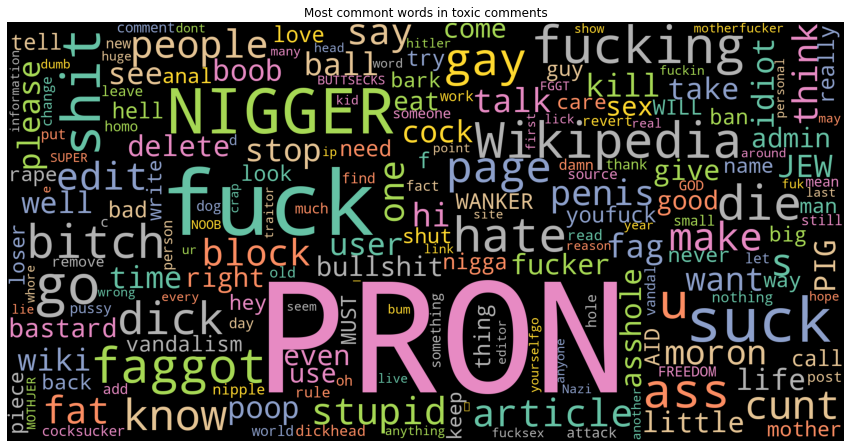

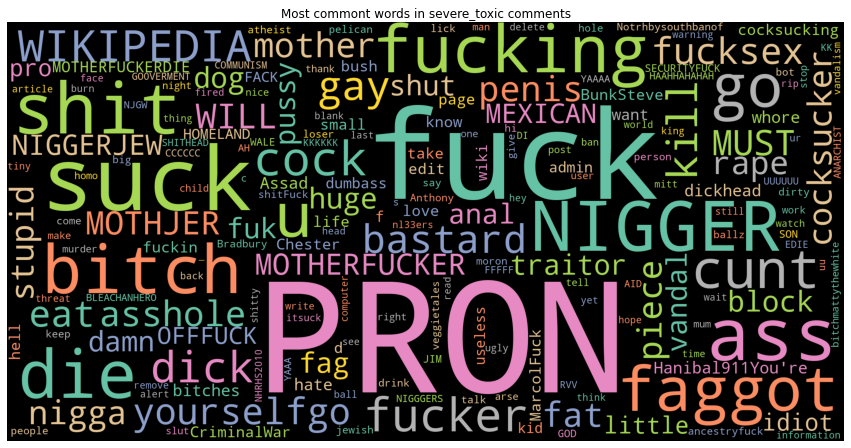

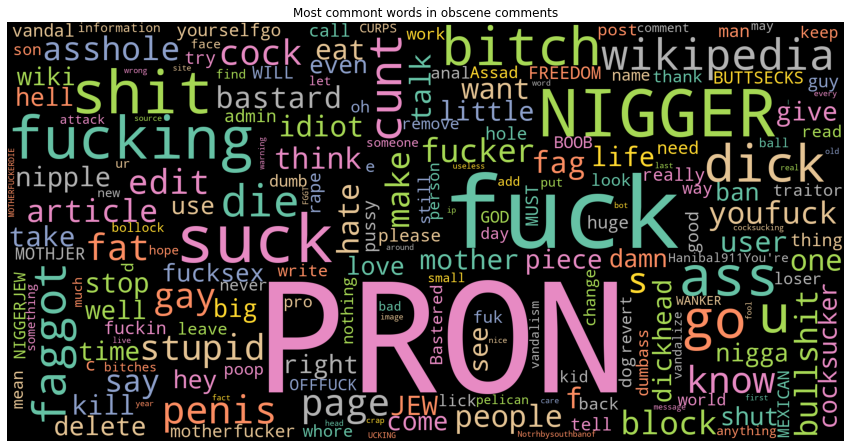

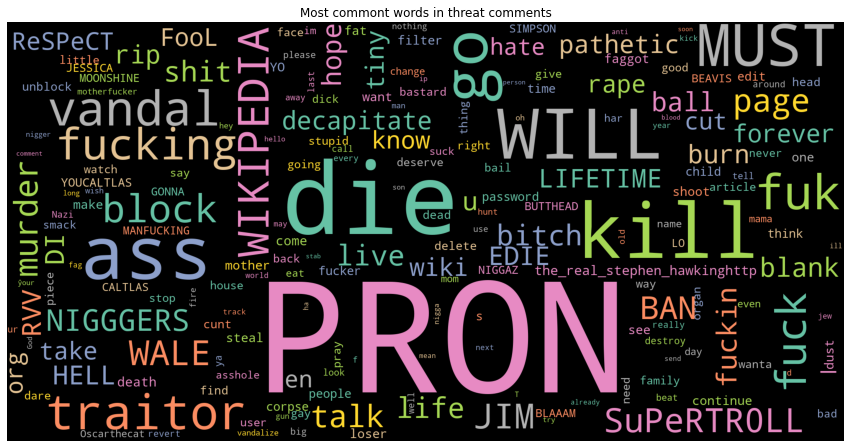

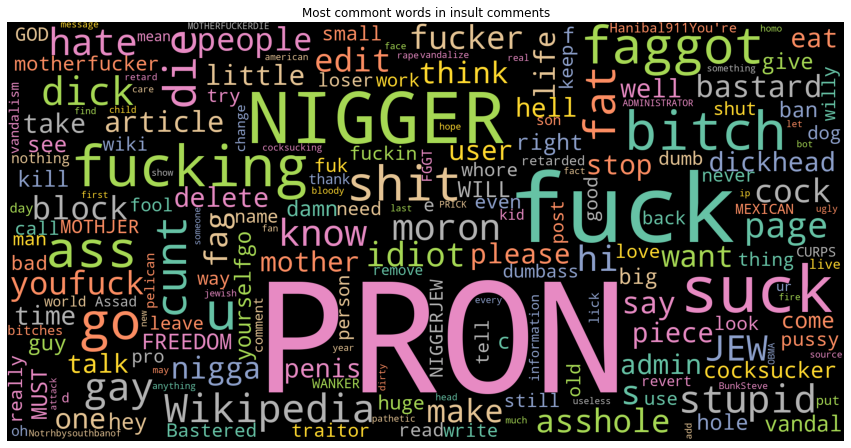

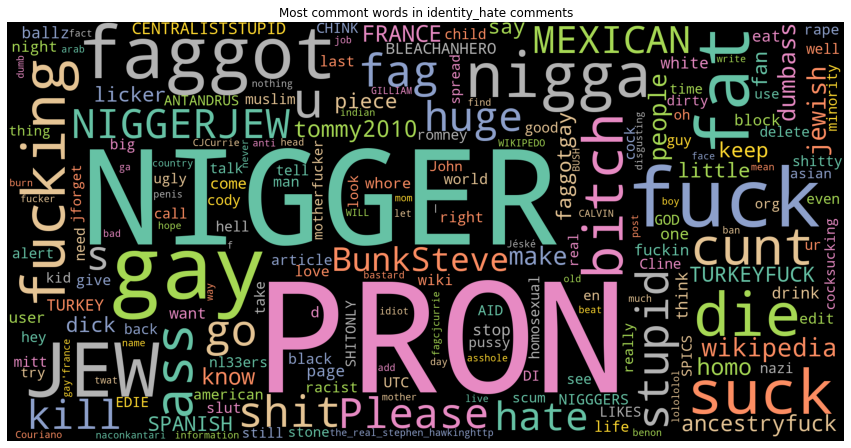

In [9]:
# for each toxicity type creating word cloud
for typ in toxicity_types:
    # choosing data
    toxic_list = train_data[train_data[typ]==1]["lemmatized"].tolist()
    texts = " ".join(toxic_list)
    # wordcloud creation
    cloud = wordcloud.WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(texts)
    
    #showing cloud
    plt.figure(figsize=(15,15))
    plt.title(f"Most commont words in {typ} comments")
    plt.imshow(cloud)
    plt.axis("off")
    plt.show()


del toxic_list, texts, cloud

I will not be using lemmatized words in the model, as sometimes different forms carry a different meaning. Let's start preparing training set

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score
from sklearn.model_selection import train_test_split
# classificators
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from tensorflow.python.keras.utils import np_utils
# tensorflow and keras
import keras
from keras import regularizers, optimizers,metrics
from keras.layers import Activation, Embedding, Dense, Dropout, Input, LSTM, Bidirectional, Conv1D,MaxPooling1D
from keras.models import Sequential
from keras.initializers import Constant

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import History,EarlyStopping, ModelCheckpoint

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [8]:
# removing some of the punctuation
def remove_punctuation(text):
    signs = ["\n","\xa0","-","_","+",":","=","]","["]
    for sign in signs:
        text = text.replace(sign," ")
    text = text.replace("\'","'")
    return text

In [ ]:
# defining features and target
X = [remove_punctuation(x) for x in train_data["comment_text"]]
y = train_data["is_toxic"]

In [13]:
# train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [14]:
# baseline model - logistic regression
X_train_r,X_test_r,y_train_r,y_test_r = train_test_split(train_data["lemmatized"],y,test_size=0.2)

pipeline = make_pipeline(CountVectorizer(),LogisticRegression())
pipeline.fit(X_train_r,y_train_r)
preds = pipeline.predict(X_test_r)
print(f"F1 score : {f1_score(y_test_r,preds)}, precision: {precision_score(y_test_r,preds)},recall: {recall_score(y_test_r,preds)}")

C:\Users\szklarnia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 score : 0.6985936906119345, precision: 0.806376133372331,recall: 0.616227089852481


In [ ]:
del train_data

In [ ]:
# preparing texts for nn - tokenizing, encoding,padding, creating embedding matrix using spacy vectors

# tokenizing
t = Tokenizer()
t.fit_on_texts(X_train)

vocab_size = len(t.word_index)+1 

# integer encoding
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)

# creating embedding matrix
embedding_matrix = np.zeros((vocab_size,300))
no_vecs = 0

for word,i in t.word_index.items():
    vec = nlp(word).vector
    embedding_matrix[i] = vec
    # finding empty vectors
    if (vec == np.zeros(300)).sum() == 300:
        no_vecs += 1

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)

np.save("embedding.npy",embedding_matrix)

In [13]:
import pickle

with open("tokenizer.pickle", 'rb') as handle:
    t = pickle.load(handle)
embedding_matrix = np.load("embedding.npy")

In [14]:
vocab_size = len(t.word_index)+1 


In [21]:

# integer encoding
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)

In [ ]:
# mean length of comment, for padding
np.mean([len(x) for x in encoded_train])

In [ ]:
# padding
padded_train = pad_sequences(encoded_train,maxlen=70 , padding="post")
padded_test = pad_sequences(encoded_test,maxlen=70 , padding="post")

In [ ]:
# defining model - embedding layer, two stacked LSTMs, one dense and dense output layer

model = Sequential()

model.add(Embedding(vocab_size,
                   300,
                   embeddings_initializer = Constant(embedding_matrix),
                   input_length = 70,
                   trainable=False))
model.add(LSTM(64,return_sequences=True))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(LSTM(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           77452800  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 64)            93440     
_________________________________________________________________
activation (Activation)      (None, 70, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [ ]:
# defining callbacks, compiling model - binary crossentropy loss for binary classification

history = History()
early_stopping = EarlyStopping(monitor="val_loss",patience=4)
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=[metrics.Precision(),metrics.Recall(),"accuracy"])

In [ ]:
# fitting model
model.fit(padded_train,y_train,validation_data=(padded_test,y_test),epochs=20,batch_size=32,callbacks=[history,early_stopping])

Epoch 1/20
5589/5589 [==============================] - 240s 37ms/step - loss: 0.2717 - precision: 0.5478 - recall: 0.1680 - accuracy: 0.9076 - val_loss: 0.1363 - val_precision: 0.7944 - val_recall: 0.6653 - val_accuracy: 0.9490
Epoch 2/20
5589/5589 [==============================] - 207s 37ms/step - loss: 0.1410 - precision: 0.7911 - recall: 0.6635 - accuracy: 0.9490 - val_loss: 0.1173 - val_precision: 0.7915 - val_recall: 0.7283 - val_accuracy: 0.9534
Epoch 3/20
5589/5589 [==============================] - 204s 36ms/step - loss: 0.1293 - precision: 0.8109 - recall: 0.6974 - accuracy: 0.9528 - val_loss: 0.1211 - val_precision: 0.8912 - val_recall: 0.6050 - val_accuracy: 0.9529
Epoch 4/20
5589/5589 [==============================] - 202s 36ms/step - loss: 0.1241 - precision: 0.8348 - recall: 0.6833 - accuracy: 0.9540 - val_loss: 0.1109 - val_precision: 0.8650 - val_recall: 0.6529 - val_accuracy: 0.9549
Epoch 5/20
5589/5589 [==============================] - 202s 36ms/step - loss: 0.115

In [ ]:
# saving best model to use later
model.save("is_toxic.keras")

Multilabel classification of types of toxicity

In [9]:
# defining data for second model - only toxic comments
train_data = train_data[train_data.is_toxic == 1]

In [10]:
# defining new targets and features

X = [remove_punctuation(x) for x in train_data["comment_text"]]
y = train_data.iloc[:,2:-1].to_numpy()

In [11]:
# splitting
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [15]:
# encoding and padding (using same tokenizer)
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)

padded_train = pad_sequences(encoded_train,maxlen=70 , padding="post")
padded_test = pad_sequences(encoded_test,maxlen=70 , padding="post")

In [16]:
# for start, same architecture as above, multilabel classification output - dense layer with 6 nodes, sigmoid activation
model = Sequential()

model.add(Embedding(vocab_size,
                   300,
                   embeddings_initializer = Constant(embedding_matrix),
                   input_length = 70,
                   trainable=False))
model.add(LSTM(64,return_sequences=True))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(LSTM(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(6,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           77452800  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 64)            93440     
_________________________________________________________________
activation (Activation)      (None, 70, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [17]:
# defining callbacks and compiling
history = History()
early_stopping = EarlyStopping(monitor="val_loss",patience=4)

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [18]:
# fitting model
model.fit(padded_train,y_train,validation_data=(padded_test,y_test),epochs=45,batch_size=32,callbacks=[history,early_stopping])

Epoch 1/45
562/562 [==============================] - 32s 47ms/step - loss: 0.4916 - accuracy: 0.7552 - val_loss: 0.3869 - val_accuracy: 0.9482
Epoch 2/45
562/562 [==============================] - 27s 48ms/step - loss: 0.4043 - accuracy: 0.9530 - val_loss: 0.3762 - val_accuracy: 0.9482
Epoch 3/45
562/562 [==============================] - 27s 48ms/step - loss: 0.3694 - accuracy: 0.9520 - val_loss: 0.3174 - val_accuracy: 0.9482
Epoch 4/45
562/562 [==============================] - 26s 47ms/step - loss: 0.3302 - accuracy: 0.9527 - val_loss: 0.3096 - val_accuracy: 0.9482
Epoch 5/45
562/562 [==============================] - 27s 48ms/step - loss: 0.3210 - accuracy: 0.9522 - val_loss: 0.3106 - val_accuracy: 0.9482
Epoch 6/45
562/562 [==============================] - 27s 48ms/step - loss: 0.3131 - accuracy: 0.9534 - val_loss: 0.3067 - val_accuracy: 0.9482
Epoch 7/45
562/562 [==============================] - 26s 47ms/step - loss: 0.3055 - accuracy: 0.9537 - val_loss: 0.3038 - val_accuracy:

In [ ]:
# saving model
model.save("toxicity_type.keras")

In [19]:
# further evaluations
preds = model.predict(padded_test)

In [20]:
from sklearn.metrics import hamming_loss


In [21]:
hamming_loss(y_test,preds.round())

0.12583444592790388

In [22]:
f1_score(y_test,preds.round(),average="micro")

0.8148835179224181

In [23]:
precision_score(y_test,preds.round(),average="micro")

0.8859888480246767

In [24]:
recall_score(y_test,preds.round(),average="micro")

0.7543434343434343

In [25]:
# single class evaluations
cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
for i in range(y_test.shape[1]):
  true = y_test[:,i]
  pred = preds[:,i].round()
  print(f"For {cols[i]} F1_score: {f1_score(true,pred)}, recall: {recall_score(true,pred)}, precision: {precision_score(true,pred)}")

For toxic F1_score: 0.9733866362078812, recall: 1.0, precision: 0.9481530930129061
For severe_toxic F1_score: 0.0, recall: 0.0, precision: 0.0
For obscene F1_score: 0.8006029285099052, recall: 0.7612612612612613, precision: 0.8442325158946412
For threat F1_score: 0.0, recall: 0.0, precision: 0.0
For insult F1_score: 0.6680141485598788, recall: 0.5846970367094206, precision: 0.779021803182086
For identity_hate F1_score: 0.11158798283261803, recall: 0.06046511627906977, precision: 0.7222222222222222


C:\Users\szklarnia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classes with high imbalance are giving very low results. As we have only 6 classes it might be more accurate to train separate classifiers for each class, and multilabel examples are hard to oversample (oversampled instanced are not assigned to other classes and in this task classes often overlap . I'll also remove "simple" toxicity, as this class is almost entirely made of 1st class and we kind of "double" the first classifier with this label. I left only best models in the notebook, after some testing

## 1. Severe Toxic  
Resample data to balance the classes (using SMOTE), add conv1D layer before LSTM, one Bidirectional instead of two unidirectional LSTM.  
Initial scores: recall - 0.0, precision - 0.0

In [12]:
# creating target - only severe toxic labels
y_train_st,y_test_st = y_train[:,1].reshape(y_train.shape[0],1),y_test[:,1].reshape(y_test.shape[0],1)

In [13]:
# resampling - oversampling to 1/2 ratio, undersampling to 1/1
oversampler = SMOTE(0.5)
undersampler = RandomUnderSampler(1)
X_smote,y_train_st = oversampler.fit_resample(padded_train,y_train_st)
X_smote,y_train_st = undersampler.fit_resample(X_smote,y_train_st)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [14]:
# class balance after resampling
np.unique(y_train_st,return_counts=True)

(array([0, 1]), array([8181, 8181]))

In [15]:
model = Sequential()

model.add(Embedding(vocab_size,
                   300,
                   embeddings_initializer = Constant(embedding_matrix),
                   input_length = 70,
                   trainable=False))


model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))


model.add(Bidirectional(LSTM(64)))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           77452800  
_________________________________________________________________
conv1d (Conv1D)              (None, 70, 32)            28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 35, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 35, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [16]:
# defining callbacks and compiling
history = History()
early_stopping = EarlyStopping(monitor="val_loss",patience=7)

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",metrics.Precision(),metrics.Recall()])

In [17]:
model.fit(X_smote,y_train_st,validation_data=(padded_test,y_test_st),epochs=45,batch_size=32,callbacks=[history,early_stopping])

Epoch 1/45
512/512 [==============================] - 16s 13ms/step - loss: 0.5868 - accuracy: 0.6685 - precision: 0.6903 - recall: 0.6119 - val_loss: 0.3476 - val_accuracy: 0.8781 - val_precision: 0.2513 - val_recall: 0.2857
Epoch 2/45
512/512 [==============================] - 5s 10ms/step - loss: 0.3657 - accuracy: 0.8408 - precision: 0.8784 - recall: 0.7861 - val_loss: 0.2755 - val_accuracy: 0.8774 - val_precision: 0.3156 - val_recall: 0.4914
Epoch 3/45
512/512 [==============================] - 5s 10ms/step - loss: 0.3079 - accuracy: 0.8672 - precision: 0.9006 - recall: 0.8258 - val_loss: 0.2945 - val_accuracy: 0.8974 - val_precision: 0.3353 - val_recall: 0.3229
Epoch 4/45
512/512 [==============================] - 5s 10ms/step - loss: 0.2859 - accuracy: 0.8714 - precision: 0.8979 - recall: 0.8372 - val_loss: 0.2636 - val_accuracy: 0.8954 - val_precision: 0.3578 - val_recall: 0.4314
Epoch 5/45
512/512 [==============================] - 5s 10ms/step - loss: 0.2697 - accuracy: 0.881

In [18]:
model.save("/content/drive/MyDrive/data_science/severe_toxic.keras")

In [19]:
pred = model.predict(padded_test).round()

print(f"F1 score - {f1_score(y_test_st,pred)}, Recall  -{recall_score(y_test_st,pred)}, Precision - {precision_score(y_test_st,pred)}")

F1 score - 0.3891050583657588, Recall  -0.42857142857142855, Precision - 0.35629453681710216


## 2. Threat  
Same strategy as for severe toxicity . 
Initial scores - recall = 0.0, precision = 0.0


In [20]:
# defining target
y_train_t,y_test_t = y_train[:,3].reshape(y_train.shape[0],1),y_test[:,3].reshape(y_test.shape[0],1)

In [21]:
# resampling
oversampler = SMOTE(0.5)
undersampler = RandomUnderSampler(1)
X_smote,y_train_t = oversampler.fit_resample(padded_train,y_train_t)
X_smote,y_train_t = undersampler.fit_resample(X_smote,y_train_t)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [22]:
model = Sequential()

model.add(Embedding(vocab_size,
                   300,
                   embeddings_initializer = Constant(embedding_matrix),
                   input_length = 70,
                   trainable=False))


model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(64)))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 300)           77452800  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 70, 32)            28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 35, 32)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 35, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               49664     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [23]:
history = History()
early_stopping = EarlyStopping(monitor="val_loss",patience=7)

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",metrics.Precision(),metrics.Recall()])

In [24]:
model.fit(X_smote,y_train_t,validation_data=(padded_test,y_test_t),epochs=45,batch_size=32,callbacks=[history,early_stopping])

Epoch 1/45
545/545 [==============================] - 11s 14ms/step - loss: 0.4936 - accuracy: 0.7555 - precision_1: 0.7418 - recall_1: 0.8108 - val_loss: 0.3895 - val_accuracy: 0.8774 - val_precision_1: 0.0616 - val_recall_1: 0.2101
Epoch 2/45
545/545 [==============================] - 7s 12ms/step - loss: 0.2511 - accuracy: 0.9206 - precision_1: 0.9422 - recall_1: 0.8972 - val_loss: 0.2077 - val_accuracy: 0.9328 - val_precision_1: 0.1239 - val_recall_1: 0.1957
Epoch 3/45
545/545 [==============================] - 7s 12ms/step - loss: 0.2006 - accuracy: 0.9297 - precision_1: 0.9488 - recall_1: 0.9066 - val_loss: 0.1894 - val_accuracy: 0.9321 - val_precision_1: 0.1592 - val_recall_1: 0.2826
Epoch 4/45
545/545 [==============================] - 7s 12ms/step - loss: 0.1662 - accuracy: 0.9428 - precision_1: 0.9584 - recall_1: 0.9258 - val_loss: 0.1726 - val_accuracy: 0.9328 - val_precision_1: 0.1694 - val_recall_1: 0.3043
Epoch 5/45
545/545 [==============================] - 7s 13ms/step 

In [25]:
model.save("/content/drive/MyDrive/data_science/threat.keras")

In [26]:
pred = model.predict(padded_test).round()

print(f"F1 score - {f1_score(y_test_t,pred)}, Recall  -{recall_score(y_test_t,pred)}, Precision - {precision_score(y_test_t,pred)}")

F1 score - 0.3640897755610973, Recall  -0.5289855072463768, Precision - 0.27756653992395436


## 3. Insult  
64 filter convolution, two bidirectional LSTMs, classes balanced, so no resampling.  
Initial scores: recall: 0.5545294635004397, precision: 0.7970922882427307

In [27]:
y_train_i,y_test_i = y_train[:,4].reshape(y_train.shape[0],1),y_test[:,4].reshape(y_test.shape[0],1)

In [28]:
np.unique(y_train_i,return_counts=True)

(array([0, 1]), array([8899, 9075]))

In [29]:
model = Sequential()

model.add(Embedding(vocab_size,
                   300,
                   embeddings_initializer = Constant(embedding_matrix),
                   input_length = 70,
                   trainable=False))


model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.6))


model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Bidirectional(LSTM(64)))
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.6))


model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 300)           77452800  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 70, 64)            57664     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 35, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 35, 64)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 35, 128)           66048     
_________________________________________________________________
activation_4 (Activation)    (None, 35, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 35, 128)          

In [30]:
history = History()
early_stopping = EarlyStopping(monitor="val_loss",patience=7)

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",metrics.Precision(),metrics.Recall()])

In [31]:
model.fit(padded_train,y_train_i,validation_data=(padded_test,y_test_i),epochs=45,batch_size=32,callbacks=[history,early_stopping])

Epoch 1/45
562/562 [==============================] - 19s 21ms/step - loss: 0.6515 - accuracy: 0.6064 - precision_2: 0.6122 - recall_2: 0.6092 - val_loss: 0.5469 - val_accuracy: 0.7323 - val_precision_2: 0.7420 - val_recall_2: 0.7057
Epoch 2/45
562/562 [==============================] - 10s 17ms/step - loss: 0.5591 - accuracy: 0.7338 - precision_2: 0.7423 - recall_2: 0.7327 - val_loss: 0.5320 - val_accuracy: 0.7339 - val_precision_2: 0.7011 - val_recall_2: 0.8080
Epoch 3/45
562/562 [==============================] - 10s 17ms/step - loss: 0.5380 - accuracy: 0.7482 - precision_2: 0.7514 - recall_2: 0.7487 - val_loss: 0.5402 - val_accuracy: 0.7332 - val_precision_2: 0.6909 - val_recall_2: 0.8362
Epoch 4/45
562/562 [==============================] - 8s 14ms/step - loss: 0.5300 - accuracy: 0.7548 - precision_2: 0.7526 - recall_2: 0.7647 - val_loss: 0.5181 - val_accuracy: 0.7519 - val_precision_2: 0.7744 - val_recall_2: 0.7052
Epoch 5/45
562/562 [==============================] - 8s 14ms/ste

In [32]:
model.save("/content/drive/MyDrive/data_science/insult.keras")

In [33]:
pred = model.predict(padded_test).round()

print(f"F1 score - {f1_score(y_test_i,pred)}, Recall  -{recall_score(y_test_i,pred)}, Precision - {precision_score(y_test_i,pred)}")

F1 score - 0.7525453740593183, Recall  -0.762673844773441, Precision - 0.7426823940585409


## 4. Identity Hate  
Same as threat and severe toxic.  
Initial scores: recall: 0.116, precision: 0.769

In [34]:
y_train_ih,y_test_ih = y_train[:,-1].reshape(y_train.shape[0],1),y_test[:,-1].reshape(y_test.shape[0],1)

In [35]:
y_train_ih.shape

(17974, 1)

In [36]:
oversampler = SMOTE(0.5)
undersampler = RandomUnderSampler(1)
X_smote,y_train_ih = oversampler.fit_resample(padded_train,y_train_ih)
X_smote,y_train_ih = undersampler.fit_resample(X_smote,y_train_ih)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [37]:
np.unique(y_train_ih,return_counts=True)

(array([0, 1]), array([8136, 8136]))

In [38]:
# for start, same architecture as above, multilabel classification output - dense layer with 6 nodes, sigmoid activation
model = Sequential()

model.add(Embedding(vocab_size,
                   300,
                   embeddings_initializer = Constant(embedding_matrix),
                   input_length = 70,
                   trainable=False))


model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# model.add(LSTM(64,return_sequences=True))
# model.add(Activation("relu"))
# model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(64)))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 300)           77452800  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 70, 32)            28832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 35, 32)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 35, 32)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               49664     
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

In [39]:
# defining callbacks and compiling
history = History()
early_stopping = EarlyStopping(monitor="val_loss",patience=7)

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",metrics.Precision(),metrics.Recall()])

In [40]:
model.fit(X_smote,y_train_ih,validation_data=(padded_test,y_test_ih),epochs=45,batch_size=32,callbacks=[history,early_stopping])

Epoch 1/45
509/509 [==============================] - 11s 15ms/step - loss: 0.5696 - accuracy: 0.7041 - precision_3: 0.7484 - recall_3: 0.6061 - val_loss: 0.4535 - val_accuracy: 0.7879 - val_precision_3: 0.2663 - val_recall_3: 0.7356
Epoch 2/45
509/509 [==============================] - 6s 13ms/step - loss: 0.3250 - accuracy: 0.8638 - precision_3: 0.8750 - recall_3: 0.8509 - val_loss: 0.3307 - val_accuracy: 0.8527 - val_precision_3: 0.3536 - val_recall_3: 0.7139
Epoch 3/45
509/509 [==============================] - 6s 13ms/step - loss: 0.2850 - accuracy: 0.8865 - precision_3: 0.8865 - recall_3: 0.8862 - val_loss: 0.2631 - val_accuracy: 0.8805 - val_precision_3: 0.4117 - val_recall_3: 0.6779
Epoch 4/45
509/509 [==============================] - 6s 13ms/step - loss: 0.2483 - accuracy: 0.9009 - precision_3: 0.8988 - recall_3: 0.9009 - val_loss: 0.3170 - val_accuracy: 0.8607 - val_precision_3: 0.3738 - val_recall_3: 0.7476
Epoch 5/45
509/509 [==============================] - 6s 12ms/step 

In [41]:
model.save("/content/drive/MyDrive/data_science/identity_hate.keras")

In [42]:
pred = model.predict(padded_test).round()

print(f"F1 score - {f1_score(y_test_ih,pred)}, Recall  -{recall_score(y_test_ih,pred)}, Precision - {precision_score(y_test_ih,pred)}")

F1 score - 0.5393835616438356, Recall  -0.7572115384615384, Precision - 0.41888297872340424


## 5. Obscene  
Two bidirectional LSTMs.  
Initial scores:recall: 0.7501024170421958, precision: 0.869833729216152


In [43]:
# creating target - only severe toxic labels
y_train_o,y_test_o = y_train[:,2].reshape(y_train.shape[0],1),y_test[:,2].reshape(y_test.shape[0],1)

In [44]:
model = Sequential()

model.add(Embedding(vocab_size,
                   300,
                   embeddings_initializer = Constant(embedding_matrix),
                   input_length = 70,
                   trainable=False))


model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(64)))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))


model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 300)           77452800  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 70, 32)            28832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 35, 32)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 35, 32)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 35, 128)           49664     
_________________________________________________________________
activation_9 (Activation)    (None, 35, 128)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 35, 128)          

In [45]:
# defining callbacks and compiling
history = History()
early_stopping = EarlyStopping(monitor="val_loss",patience=7)

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",metrics.Precision(),metrics.Recall()])

In [46]:
model.fit(padded_train,y_train_o,validation_data=(padded_test,y_test_o),epochs=45,batch_size=32,callbacks=[history,early_stopping])

Epoch 1/45
562/562 [==============================] - 18s 22ms/step - loss: 0.5651 - accuracy: 0.7077 - precision_4: 0.7248 - recall_4: 0.7789 - val_loss: 0.4238 - val_accuracy: 0.8175 - val_precision_4: 0.8565 - val_recall_4: 0.7831
Epoch 2/45
562/562 [==============================] - 10s 18ms/step - loss: 0.4482 - accuracy: 0.8105 - precision_4: 0.8298 - recall_4: 0.8196 - val_loss: 0.4119 - val_accuracy: 0.8222 - val_precision_4: 0.8366 - val_recall_4: 0.8213
Epoch 3/45
562/562 [==============================] - 10s 18ms/step - loss: 0.4306 - accuracy: 0.8129 - precision_4: 0.8256 - recall_4: 0.8291 - val_loss: 0.4037 - val_accuracy: 0.8278 - val_precision_4: 0.8494 - val_recall_4: 0.8162
Epoch 4/45
562/562 [==============================] - 8s 15ms/step - loss: 0.4098 - accuracy: 0.8250 - precision_4: 0.8430 - recall_4: 0.8355 - val_loss: 0.3984 - val_accuracy: 0.8320 - val_precision_4: 0.8482 - val_recall_4: 0.8277
Epoch 5/45
562/562 [==============================] - 8s 14ms/ste

In [47]:
model.save("/content/drive/MyDrive/data_science/obscene.keras")

In [48]:
pred = model.predict(padded_test).round()

print(f"F1 score - {f1_score(y_test_o,pred)}, Recall  -{recall_score(y_test_o,pred)}, Precision - {precision_score(y_test_o,pred)}")

F1 score - 0.8277365896205844, Recall  -0.8056027164685908, Precision - 0.8511210762331839


# Effects of multiple classifiers 
In every single case after resampling and changing architecture scores increased. For two categories that were scored 0.0 in first model now I was able to get F1 score of around 0.35. That score is still very small and these models cannot be called accurate, but the improvement is substantial. To make the models better there should be more examples of the class. For identity hate score grown to 0.53. While still low, this model could have some applicability. For Obscene the score rose to 0.82 and for insults to 0.75. Individual modelling achieved substantially better results in classification. Still, more training data should be used to tune the model to achieve more stable results.